In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset
The model with a binomial regression on the logit of its parameter is implemented. The spatial factor w is leaved there and the random intercepts stayed there.

In [18]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "Quota", "count_highwind", "type_rural", "type_urban"], axis=1)

In [19]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [20]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [21]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [22]:
model_180 = FetchModel("binomial").compile()

In [23]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances

}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180 = az.from_cmdstanpy(fit_180)

16:54:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:59:57 - cmdstanpy - INFO - CmdStan done processing.
16:59:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial.stan', line 51, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, 

In [24]:
post_pred = PostPred(posterior_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

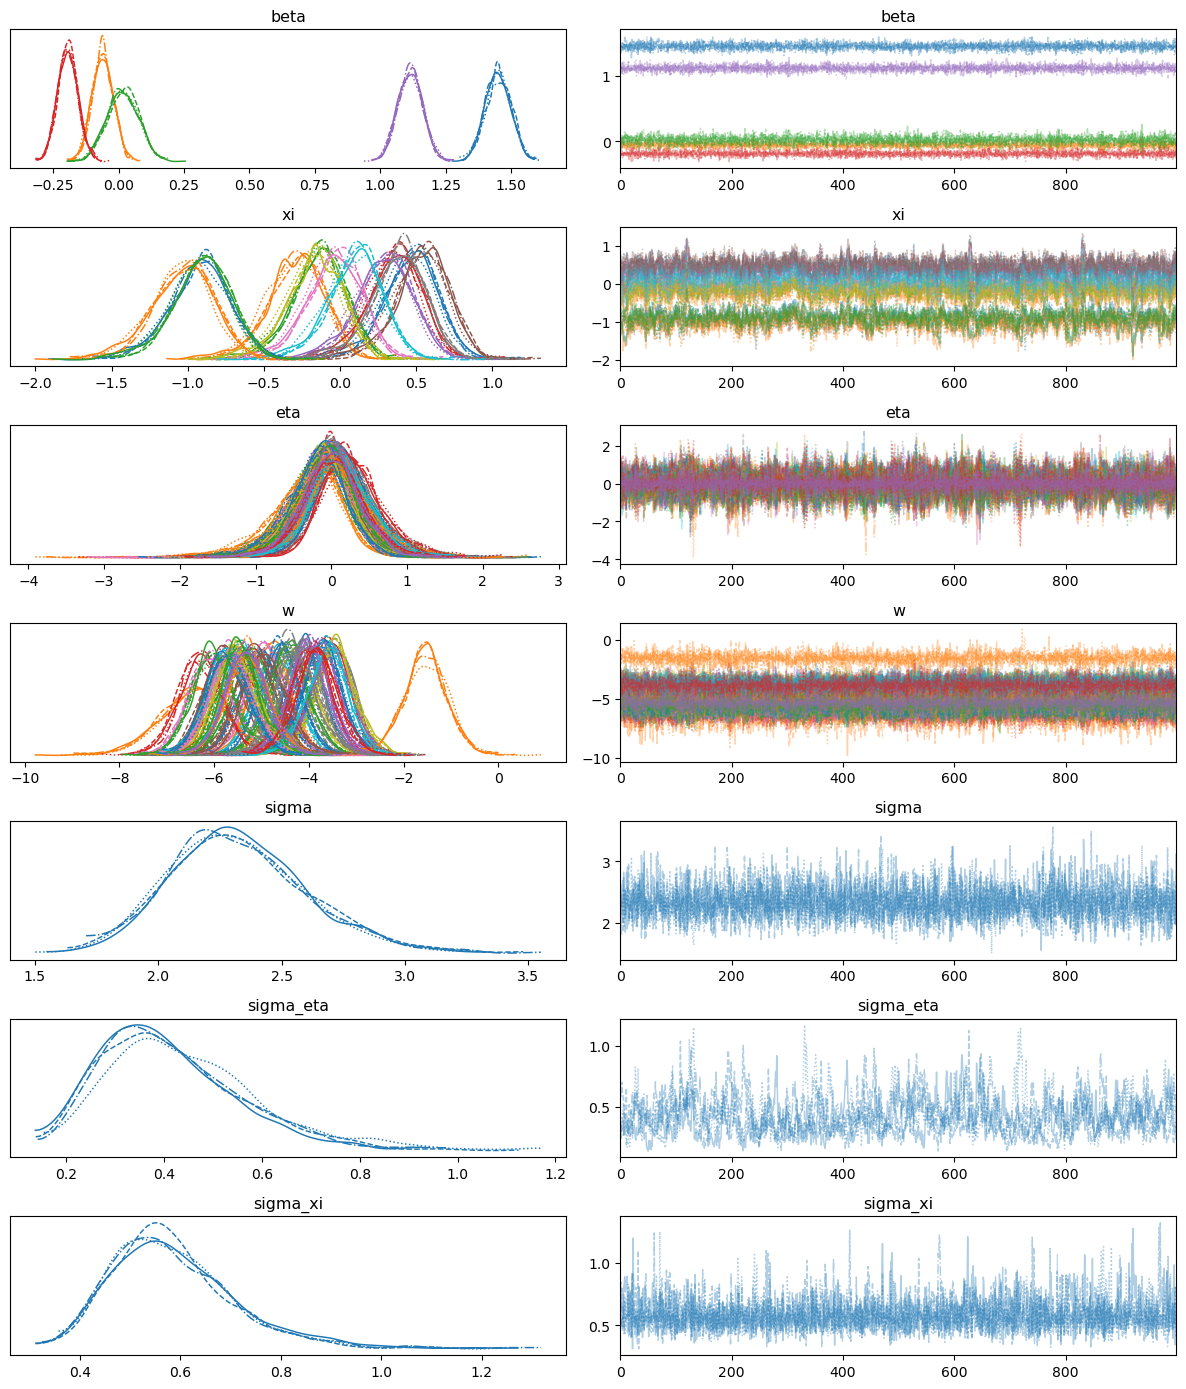

In [25]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'w', 'sigma', 'sigma_eta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [26]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2721.96    73.58
p_waic      113.83        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2722.83    73.63
p_loo      114.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2663   99.9%
 (0.5, 0.7]   (ok)          3    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [27]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [28]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 140

The total number of outliers in the test set is: 53

The MSE is: 2.1313025210084033

The MAE is: 0.7182247899159664

The MAD is: 0.0

The MSE in the test set is: 2.4001751313485116

The MAE in the test set is: 0.7591943957968477

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9632352941176471

The percentage of observations inside the CI of the test is: 0.9535901926444834



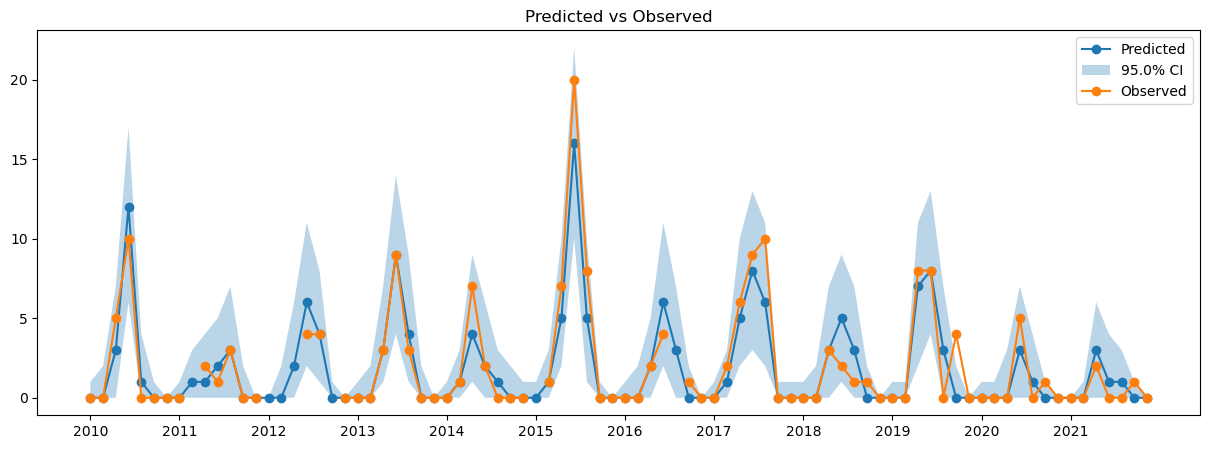

In [35]:
station_num_to_plot = 27 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2022))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

Tolgo l'effetto dello spazio integrandolo negli eta, i coefficienti vengono tutti zeri

In [36]:
model_180_bis = FetchModel("binomial_bis").compile()

17:05:50 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\AAB4F7~1.23-\BAYESI~1\BAYESI~1\main\Modello\stan\binomial_bis.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\A.A. 23-24\Bayesian statistics\Bayesian_Project\main\Modello\stan\binomial_bis.exe
17:07:34 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\A.A. 23-24\Bayesian statistics\Bayesian_Project\main\Modello\stan\binomial_bis.exe


In [37]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances

}

fit_180_bis = model_180_bis.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180_bis = az.from_cmdstanpy(fit_180_bis)

17:07:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:10:18 - cmdstanpy - INFO - CmdStan done processing.
17:10:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'binomial_bis.stan', line 49, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'binomial_bis.stan', line 49, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'binomial_bis.stan', line 49, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'binomial_bis.stan', line 49, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [38]:
post_pred = PostPred(posterior_180_bis, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

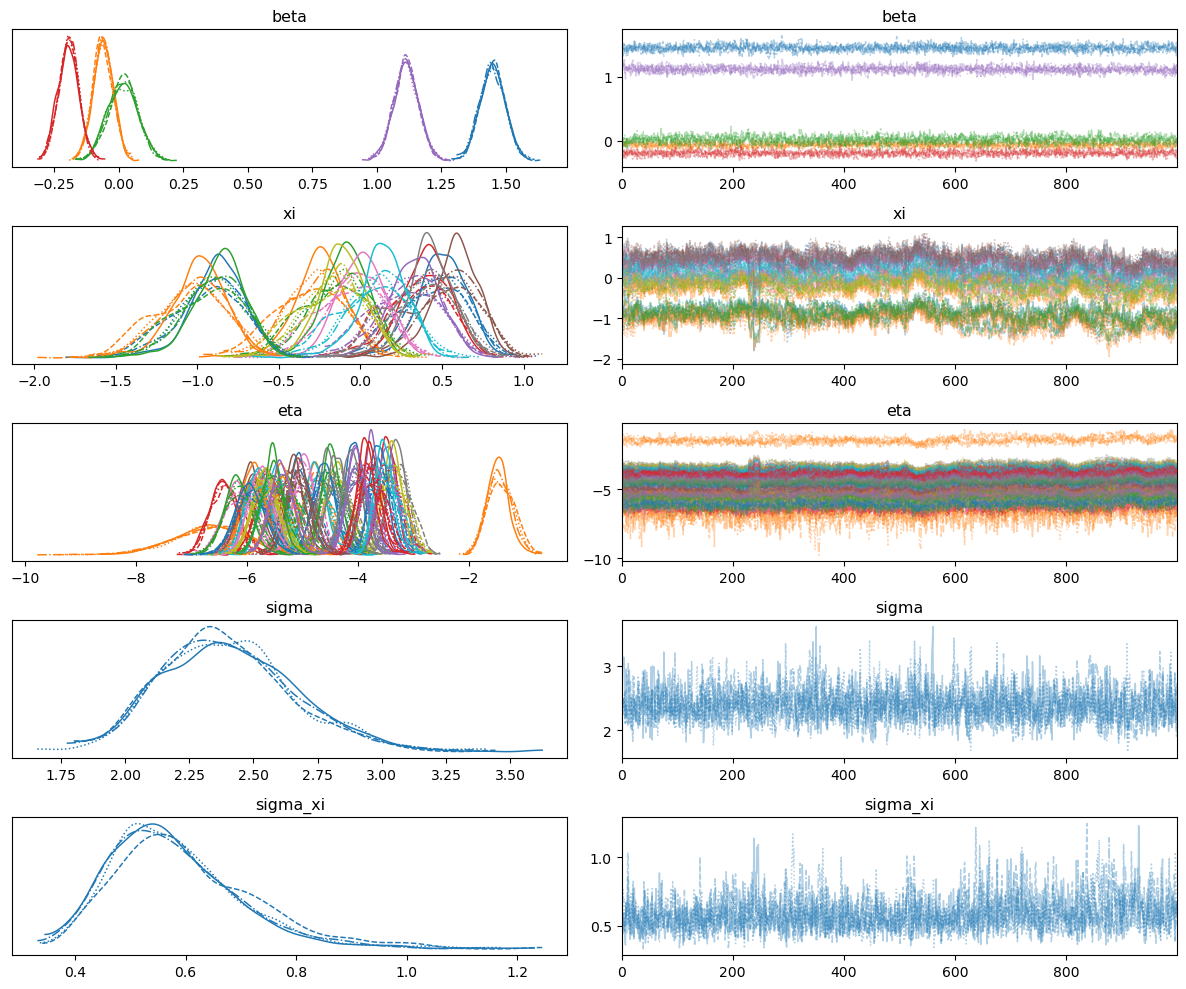

In [41]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [42]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2721.86    73.60
p_waic      113.40        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2722.68    73.65
p_loo      114.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2663   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [43]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [47]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The proportion of outliers is: {len(outliers)/len(Y_obs)}\n')
print(f'The proportion of outliers in the test set is: {len(outliers_test)/len(idx_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The proportion of outliers is: 0.05288822205551388

The proportion of outliers in the test set is: 0.0446584938704028

The MSE is: 2.141609768907563

The MAE is: 0.7178308823529411

The MAD is: 0.0

The MSE in the test set is: 2.403677758318739

The MAE in the test set is: 0.7591943957968477

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9629726890756303

The percentage of observations inside the CI of the test is: 0.9553415061295972



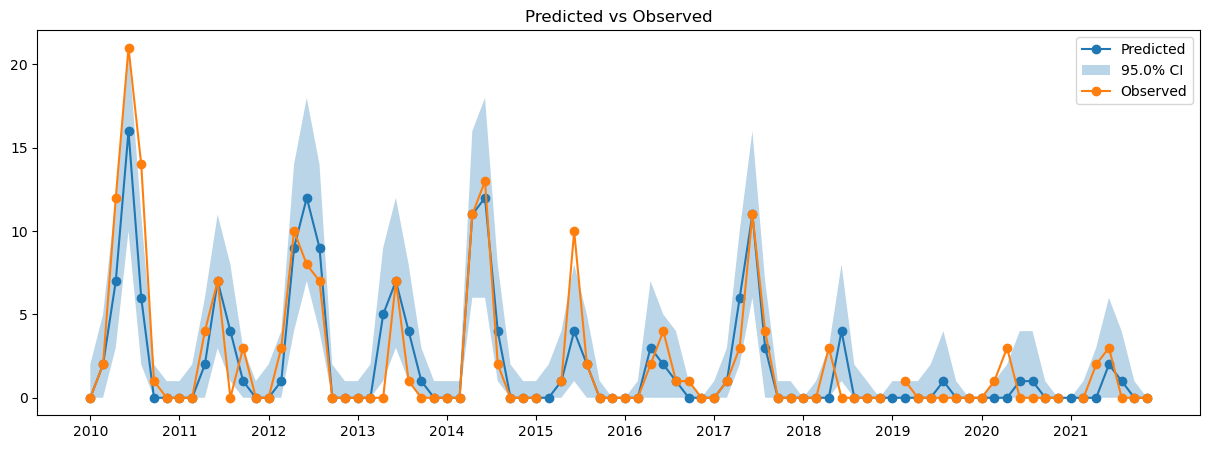

In [48]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2022))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()